<p style="font-family:Times New Roman; font-size:120%">
    -Aleksander Nistad Sekkelsten
</p>
<h1 style="font-family:Times New Roman; font-size: 300%"><center> Machine Learning For Physics; Project 2 </center></h1>

<p style="font-family:Times New Roman; font-size:120%">
    Here, I delevop the optimization algorithms Gradient Descent, Stochastic Gradient Descent, Momentum, AdaGrad, RMSProp and ADAM. I apply them to a one dimensional second order polynomial. Lastly, I do some hyperparameter finetuning
</p>

In [1]:
import Pkg; Pkg.activate(".julia/environments/v1.10/Project.toml")
Pkg.add(["SCS", "Convex","PlotThemes","Images"])
using Plots, Random, NBInclude, LinearAlgebra, Statistics, Distributions, Convex, SCS, Zygote
using Plots.PlotMeasures
using StatsBase: sample
theme(:dao)

  Activating project at `~/.julia/environments/v1.10`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


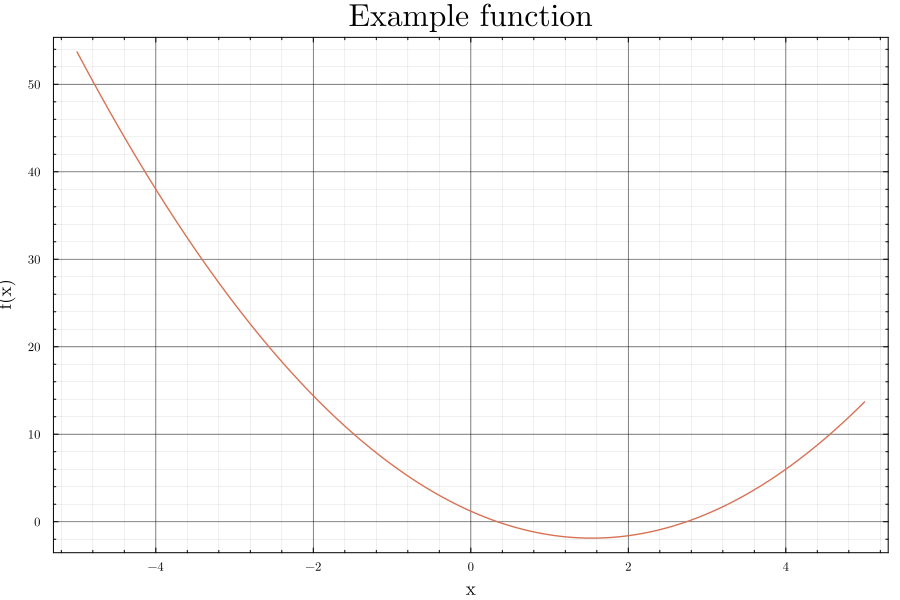

In [2]:

f(x) = 1.2 -4*x+1.3*x^2 #Random second degree polynomial
f_grad(x) = -4+2.6*x #Analytical derivative

x = range(-5,5, 100) |> collect
y=f.(x)

plot(x, f.(x), xlabel="x", ylabel="f(x)", size=(900, 600), title="Example function", titlefontsize=20, legend=false)

In [3]:
function Regression(xData, yData, numDegrees::Int64; λ=0) #Does linear regression
    DesignMatrix = zeros(length(xData), numDegrees+1) #Creating designmatrix
    for i in 1:numDegrees+1
        DesignMatrix[:,i].=xData.^(i-1) 
    end
    Hessian = Transpose(DesignMatrix)*DesignMatrix #Hessian Matrix
    beta = inv(Hessian+λ*I)*Transpose(DesignMatrix)*yData #Analytical β values
    return beta
end

function RandomPolyDegModel(xData, betas)
    #This function will calculate ỹ = ∑ β_i x^i for any number of degrees 
    N = length(xData)
    DesignMatrix = zeros(length(xData), length(betas)) 
    for i in 1:length(betas)
        DesignMatrix[:,i].=xData.^(i-1)
    end
    est = DesignMatrix*betas
    return est
end

function SplitData(xData, yData, train_size::Float64)
    #Assumes Data : n_features, n_observations
    
    if ndims(xData)==1
        N = length(xData)
        NumTrain = Int(round(N*train_size))
            
        train_indices = sample(1:N, NumTrain; replace=false)
        all_indices = collect(1:N)
        test_indices = [i for i in all_indices if i ∉ train_indices]
        
        xTrain = xData[train_indices]
        yTrain = yData[train_indices]
        xTest = xData[test_indices]
        yTest = yData[test_indices]
        
    elseif ndims(xData)==2 #If there are for multiple features for each datapoint i.e position, velocity
        N = length(xData[:,1])
        NumTrain = Int(round(N*train_size))
            
        train_indices = sample(1:N, NumTrain; replace=false)
        all_indices = collect(1:N)
        test_indices = [i for i in all_indices if i ∉ train_indices]
        
        xTrain = xData[train_indices,:]
        yTrain = yData[train_indices,:]
        xTest = xData[test_indices,:]
        yTest = yData[test_indices,:]
    else #This is undefined
        @warn "Array dimensions do not match the expected dimensions." 
        println("Expected: 1 or 2, but got: ", ndims(xData))
        return
    end
    return xTrain, xTest, yTrain, yTest
end

function DM(x, numDegrees) #Creates DesignMatrix
    X = zeros(length(x), numDegrees)
    for i in 1:numDegrees
        X[:,i].=x.^(i-1)
    end
    return X
end
function MSE(DesignMatrix, z, beta; λ=0)#Calculates the MSE for OLS or Ridge regression
    N = length(z) 
    if (λ==0) & (γ==0)
        MSE =  1/N*sum((z .- DesignMatrix*beta).^2)
    else
        MSE = 1/N*sum((z .- DesignMatrix*beta).^2).+λ*(sum(beta.^2))
    end
    return MSE
end


MSE (generic function with 1 method)

In [4]:
#Hyperparameters tuned
epochs=300
η = 0.001
λ = 0.001
xTrain, xTest, yTrain, yTest = SplitData(x, f.(x), 0.7) #Split data
DM_Test = DM(xTest, 3)
n = length(xTrain)
batch_size = 20
batches =Int(round(length(xTrain)/batch_size))

4

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Gradient Descend</h2>


In [5]:

theta=rand(3) #Initializing
for i in 1:epochs

    X = DM(xTrain, 3)
    gradient =(2/n)*X'*(X*theta-yTrain)
    theta-= η*gradient

    if i%100==0
        println("Epoch = ", i, "   Loss = ", MSE(DM_Test, yTest, theta; λ=0))
    end
end
println(theta)

LoadError: UndefVarError: γ not defined

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Stochastic Gradient Descend</h2>


In [6]:
theta=rand(3)
for i in 1:epochs
    
    for j in 1:batches
        a, b = Int(batch_size*(j-1)+1), Int(batch_size*(j)+1)
        if j==batches
            input, label = xTrain[a:end], yTrain[a:end]
        else
            input, label = xTrain[a:b], yTrain[a:b]
        end
        X = DM(input, 3)
        gradient =(2/batch_size)*X'*(X*theta-label)
        theta-= η*gradient
    end
    
    if i%100==0
        println("Epoch = ", i, "   Loss = ", MSE(DM_Test, yTest, theta; λ=0))
    end
end
println(theta)

LoadError: UndefVarError: γ not defined

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Stochastic Gradient Descend w/ momentum</h2>


In [7]:
v = rand(3)
γ = 0.9

theta=rand(3)
for i in 1:epochs
    for j in 1:batches
        a, b = Int(batch_size*(j-1)+1), Int(batch_size*(j)+1)
        if j==batches
            input, label = xTrain[a:end], yTrain[a:end]
        else
            input, label = xTrain[a:b], yTrain[a:b]
        end
        X = DM(input, 3)

        gradient =(2/batch_size)*X'*(X*theta-label)
        v = γ*v .+ η*gradient
        theta -= v
    end
    if i%100==0
        println("Epoch = ", i, "   Loss = ", MSE(DM_Test, yTest, theta; λ=0))
    end
end
println(theta)

Epoch = 100   Loss = 0.0027018759462516424
Epoch = 200   Loss = 2.0039260963720383e-6
Epoch = 300   Loss = 1.486270928252647e-9
[1.1999415309671269, -3.9999992716566233, 1.3000038856182567]


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">ADAM</h2>


In [8]:
δ = 1e-8
ρ_1=0.9
ρ_2=0.999
r=zeros(3)
s=zeros(3)
t=0  
η=0.1

theta=rand(3)
for i in 1:epochs

    for j in 1:batches
        a, b = Int(batch_size*(j-1)+1), Int(batch_size*(j)+1)
        if j==batches
            input, label = xTrain[a:end], yTrain[a:end]
        else
            input, label = xTrain[a:b], yTrain[a:b]
        end
        X = DM(input, 3)
        grad = Zygote.gradient(theta -> MSE(X, label, theta;λ=λ), theta)[1]
        t+=1
        s = ρ_1*s .+ (1-ρ_1)*grad
        s_temp = s/(1-ρ_1^t)
        
        r = ρ_2*r .+ (1-ρ_2)*(grad.*grad)
        r_temp = r/(1-ρ_2^t)
        
        Δθ = @. η*s_temp/(δ+(r_temp).^0.5)
        theta -= Δθ
    end
    
    if (i)%100==0
        println("Epoch = ", i, "   Loss = ", MSE(DM_Test, yTest, theta; λ=0))
    end
end
println(theta)

Epoch = 100   Loss = 5.642179056428068e-6
Epoch = 200   Loss = 5.652429643278211e-6
Epoch = 300   Loss = 5.663829244792511e-6
[1.1975112497132387, -3.9994862302915153, 1.3001424163015256]


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">AdaGrad</h2>

In [9]:
δ = 1e-8
r=0
η=0.1

theta=rand(3)
for i in 1:epochs
    for j in 1:batches
        a, b = Int(batch_size*(j-1)+1), Int(batch_size*(j)+1)
        if j==batches
            input, label = xTrain[a:end], yTrain[a:end]
        else
            input, label = xTrain[a:b], yTrain[a:b]
        end
        X = DM(input, 3)
        grad = Zygote.gradient(theta -> MSE(X, label, theta), theta)[1]
        r =r .+ (grad.*grad)
        
        Δθ = @. η/(δ.+√r).*grad
        theta -= Δθ
    end
    
    if (i)%100==0
        println("Epoch = ", i, "   Loss = ", MSE(DM_Test, yTest, theta; λ=0))
    end
end
println(theta)

Epoch = 100   Loss = 19.776863260049005
Epoch = 200   Loss = 4.450856599152092
Epoch = 300   Loss = 1.0640508926521532
[1.3061086428063646, -3.659737625837872, 1.282611888157035]


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">RMSProp</h2>

In [10]:
δ = 1e-8
ρ=0.9
η=0.01
r=0

theta=rand(3)
for i in 1:epochs
    for j in 1:batches
        a, b = Int(batch_size*(j-1)+1), Int(batch_size*(j)+1)
        if j==batches
            input, label = xTrain[a:end], yTrain[a:end]
        else
            input, label = xTrain[a:b], yTrain[a:b]
        end
        X = DM(input, 3)
        grad = Zygote.gradient(theta -> MSE(X, label, theta), theta)[1]
        r = ρ*r .+ (1-ρ)*(grad.*grad)
        
        Δθ = @. η/(δ+√r)*grad
        theta -= Δθ
    end
    
    if (i)%100==0
        println("Epoch = ", i, "   Loss = ", MSE(DM_Test, yTest, theta; λ=0))
    end
end
println(theta)

Epoch = 100   Loss = 10.785176456064494
Epoch = 200   Loss = 0.0013731370574992057
Epoch = 300   Loss = 0.0013731267247486531
[1.192863756092403, -4.005849951402864, 1.297501660915354]


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Hyperparameter tuning for SGD</h2>

In [11]:
batches =Int(round(length(xTrain)/batch_size))
    
η_vals = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 7.0*1e-3] # learning rates
λ_vals = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] # Ridge penalty coefficients

MSE_vals = zeros(length(η_vals), length(λ_vals))
    
for (λ_idx, λ_val) in enumerate(λ_vals)
    for (η_idx, η_val) in enumerate(η_vals)
        
        theta=rand(3)
        for i in 1:epochs
            
            for j in 1:batches
                a, b = Int(batch_size*(j-1)+1), Int(batch_size*(j)+1)
                if j==batches
                    input, label = xTrain[a:end], yTrain[a:end]
                else
                    input, label = xTrain[a:b], yTrain[a:b]
                end
                X = DM(input, 3)
                grad = Zygote.gradient(theta -> MSE(X, label, theta;λ=λ_val), theta)[1]
                theta-= η_val*grad
            end
            
        end
        
        MSE_vals[η_idx,λ_idx] = MSE(DM_Test, yTest, theta;λ=0)
    end
end

In [12]:
hb = heatmap(MSE_vals, cmap=:acton,title="λ & learning rate MSE values", yticks=(1:7, η_vals), xticks=(1:7, λ_vals), ylabel="η",xlabel="λ")
annotate!(hb,[(j, i, text(round(MSE_vals[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:7 for j in 1:7])
hb

In [13]:
λ=0.001
η = 0.001

batch_sizes = [2, 7, 10, 35, 70]
epoch_vals = [5, 20, 50, 100, 300, 1000]
MSE_vals2 = zeros(length(batch_sizes), length(epoch_vals))
    
for (B_idx, B_val) in enumerate(batch_sizes)
    for (E_idx, E_val) in enumerate(epoch_vals)

        theta=rand(3)
        batches = Int(round(length(xTrain)/B_val))
            
        for i in 1:E_val
            for j in 1:batches
                a, b = Int(B_val*(j-1)+1), Int(B_val*(j)+1)
                if j==batches
                    input, label = xTrain[a:end], yTrain[a:end]
                else
                    input, label = xTrain[a:b], yTrain[a:b]
                end
                X = DM(input, 3)
                grad = Zygote.gradient(theta -> MSE(X, label, theta;λ=λ), theta)[1]
                theta-= η*grad
            end
        end
        MSE_vals2[B_idx,E_idx] = MSE(DM_Test, yTest, theta;λ=0)
    end
end

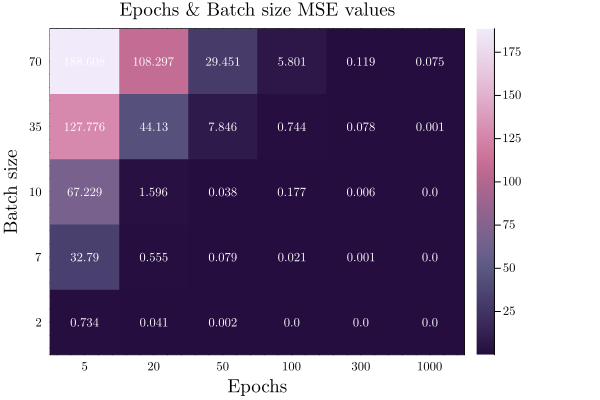

In [14]:
hb = heatmap(MSE_vals2, cmap=:acton,title="Epochs & Batch size MSE values", yticks=(1:length(batch_sizes), batch_sizes), xticks=(1:length(epoch_vals), epoch_vals), ylabel="Batch size",xlabel="Epochs")
annotate!(hb,[(j, i, text(round(MSE_vals2[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:length(batch_sizes) for j in 1:length(epoch_vals)])
hb